In [1]:
import pandas as pd
raw_dataset_path="../dataset/raw"
from os.path import join as join_pth
import matplotlib.pyplot as plt
import random
from IPython.core.display import HTML
import numpy as np


In [2]:

styles = open("./rossman-style.css", "r").read()
styles=f"<style>\n{styles}\n<\style>"
HTML(styles)


# introduction

<p align="center"><img src="./assets/rosman.jpg" height="350"  alt="rosman"/></p>>


- Rossmann, is one of the largest drug store chains in Europe with around 56,200 employees and more than 4000 stores  in Germany, Poland, Hungary, the Czech Republic, Turkey, Albania, Kosovo and Spain.
- The product range includes up to 21,700 items and can vary depending on the size of the shop and the location. In addition to drugstore goods with a focus on skin, hair, body, baby and health
- The company was founded in 1972 by Dirk Rossmann , The Rossmann family owns 60% of the company. The Hong Kong-based A.S. Watson Group owns 40%


## Roadmap
1. loading data and handling null values , check datatypes
2. Data analysis
3. feature engineering
4. create prediction model
5. model training
6. hyperparameters tuning
7. model evaluation

## Data fields


<br><br>

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends.
    - a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
    - An assortment strategy is a retail industry sales tool that optimizes the variety of goods offered for sale to consumers
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Data Loading
- load the data
- view missing values
- check data types


In [3]:
stores_df=pd.read_csv(join_pth(raw_dataset_path,"store.csv"),low_memory=False)
stores_sales_df=pd.read_csv(join_pth(raw_dataset_path,"train.csv"),low_memory=False)


In [4]:
stores_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
stores_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
stores_sales_df.info()
print("------------------------------")
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115

In [81]:
stores_sales_df['Date']=pd.to_datetime(stores_sales_df['Date'])

In [116]:
print(f"StateHoliday Values{stores_sales_df.StateHoliday.unique()} , Data type -> {stores_sales_df.StateHoliday.dtype}")

StateHoliday Values['0' 'a' 'b' 'c'] , Data type -> object


CompetitionOpenSinceMonth , CompetitionOpenSinceYear

In [83]:
compYear_comp_month_null=stores_df[(stores_df.iloc[:,4].isnull()) & (stores_df.iloc[:,5].isnull())]
print((stores_df.iloc[:,4].isnull()).count()== (stores_df.iloc[:,5].isnull()).count())
print(f"both CompetitionOpenSinceYear and CompetitionOpenSinceMonth both null count {compYear_comp_month_null.count()[0]}")

True
both CompetitionOpenSinceYear and CompetitionOpenSinceMonth both null count 354


# 1- Data preprocessing , Feature engineering
- check and handle missing values
    - CompetitionDistance
    - Promo2SinceWeek ,  Promo2SinceYear ,PromoInterval
        - check if no of stores that have promo2 = 0  equal number of  null values in this columns
    - CompetitionOpenSinceMonth , CompetitionOpenSinceYear


<p style="font-size:25;font-weight:bold">Stores Sales </p>

- no null values
<p style="font-size:25;font-weight:bold">Stores data </p>

- some null values exists we have 1115 stores
- if promo2=0 then the store has no promo months then Promo2SinceWeek,Promo2SinceYear,PromoInterval will be equal null, so we will set the promo2=0 rows Promo2SinceWeek=0 Promo2SinceYear=0 , promo2Interval=0
- for Competitor data null values we will assume that there is no competitors near the store

## 1.1 Check and handle missing values

### 1.1.1 Competition Distance

In [84]:
stores_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5594.466368,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,8479.266802,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,720.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2330.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6905.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [85]:
stores_sales_sum=stores_sales_df[['Store','Customers']].groupby(by='Store').sum()
stores_sales_sum=stores_sales_sum.merge(stores_df,on='Store')
## select same type for stores in Assortment type and store type

stores_sales_sum=stores_sales_sum[(stores_sales_sum['Assortment']=='a') & (stores_sales_sum['StoreType']=='a')]
stores_sales_sum=stores_sales_sum.sort_values(by="CompetitionDistance")

stores_sales_sum=pd.DataFrame(stores_sales_sum)

In [86]:
stores_sales_sum.sample()

,Store,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
141,142,443045,a,a,1090.0,7.0,2002.0,0,NaN,NaN,NaN


In [87]:
stores_sales_sum.corr()['Customers']

Store                        0.041872
Customers                    1.000000
CompetitionDistance         -0.187939
CompetitionOpenSinceMonth   -0.066772
CompetitionOpenSinceYear     0.056117
Promo2                      -0.234494
Promo2SinceWeek             -0.159582
Promo2SinceYear             -0.009873
Name: Customers, dtype: float64

<p style="font-size:25;font-weight:bold">Based on section 1.1.1</p>

- there is an inverse correlation relation between no of customers and Competition Distance
- so we will fill null values with the least amount that affect the sales which is the max distance

In [110]:
# fill null with max
stores_df['CompetitionDistance']=stores_df['CompetitionDistance'].fillna(stores_df['CompetitionDistance'].max())

- CompetitionOpenSinceYear and CompetitionOpenSinceMonth null values are for the same rows

### 1.1.2 Promo2 SinceWeek,SinceYear,PromoInterval

In [95]:
non_promo_stores=stores_df[(stores_df['Promo2']==0)][['Promo2','Promo2SinceYear','Promo2SinceWeek','PromoInterval']]
non_promo_stores.sample(10)

,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval
0,0,NaN,NaN,NaN
714,0,NaN,NaN,NaN
266,0,NaN,NaN,NaN
780,0,NaN,NaN,NaN
915,0,NaN,NaN,NaN
1030,0,NaN,NaN,NaN
211,0,NaN,NaN,NaN
859,0,NaN,NaN,NaN
937,0,NaN,NaN,NaN
429,0,NaN,NaN,NaN


In [96]:
non_promo_stores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 0 to 1113
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Promo2           544 non-null    int64  
 1   Promo2SinceYear  0 non-null      float64
 2   Promo2SinceWeek  0 non-null      float64
 3   PromoInterval    0 non-null      object 
dtypes: float64(2), int64(1), object(1)
memory usage: 21.2+ KB


In [111]:
stores_df[(stores_df['Promo2']==0) & ((stores_df['Promo2SinceWeek'].notnull()) | (stores_df['Promo2SinceYear'].notnull()) |(stores_df['PromoInterval'].notnull()) )].count()[0]

0

<p style="font-size:25;font-weight:bold">Based on section 1.1.2</p>

- Promo2SinceWeek Promo2SinceYear , PromoInterval are null only when promo2 equals zero ie when the store doesn't have continuous promo intervals


## EDA , Feature Engineering columns
- School-Holiday , State-Holiday
- store type
- assortment
- create new column competition open since

### School-Holiday , State-Holiday
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends.
a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- find
    - relation between school holiday and state holiday and relation between them and the sales , no of customers
    -

In [125]:
stores_sales_df.groupby(by=['SchoolHoliday','StateHoliday']).count()['Store']

SchoolHoliday  StateHoliday
0              0               819949
               a                15055
               b                  484
1              0               166210
               a                 5205
               b                 6206
               c                 4100
Name: Store, dtype: int64

In [30]:

stores_df[stores_df.isnull().sum(axis=1)>1]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [9]:
stores_sales_df['Date']=pd.to_datetime(stores_sales_df['Date'])
stores_sales_df=stores_sales_df.sort_values(by='Date')

In [10]:
rand_store_idx=random.randint(1,len(stores_sales_df))

In [45]:

store_1_non_zero=train_df[(train_df['Store']==rand_store_idx) & (train_df['Sales']!=0)]

sales_2013=store_1_non_zero[(store_1_non_zero['Date'].dt.year<2014) ]
sales_2014=store_1_non_zero[(store_1_non_zero['Date'].dt.year>=2014) & (store_1_non_zero['Date'].dt.year<2015)  ]
sales_2015=store_1_non_zero[(store_1_non_zero['Date'].dt.year>=2015) & (store_1_non_zero['Date'].dt.year<2016)  ]



In [46]:
year_df=sales_2013
month_df=year_df[year_df.Date.dt.month==1]

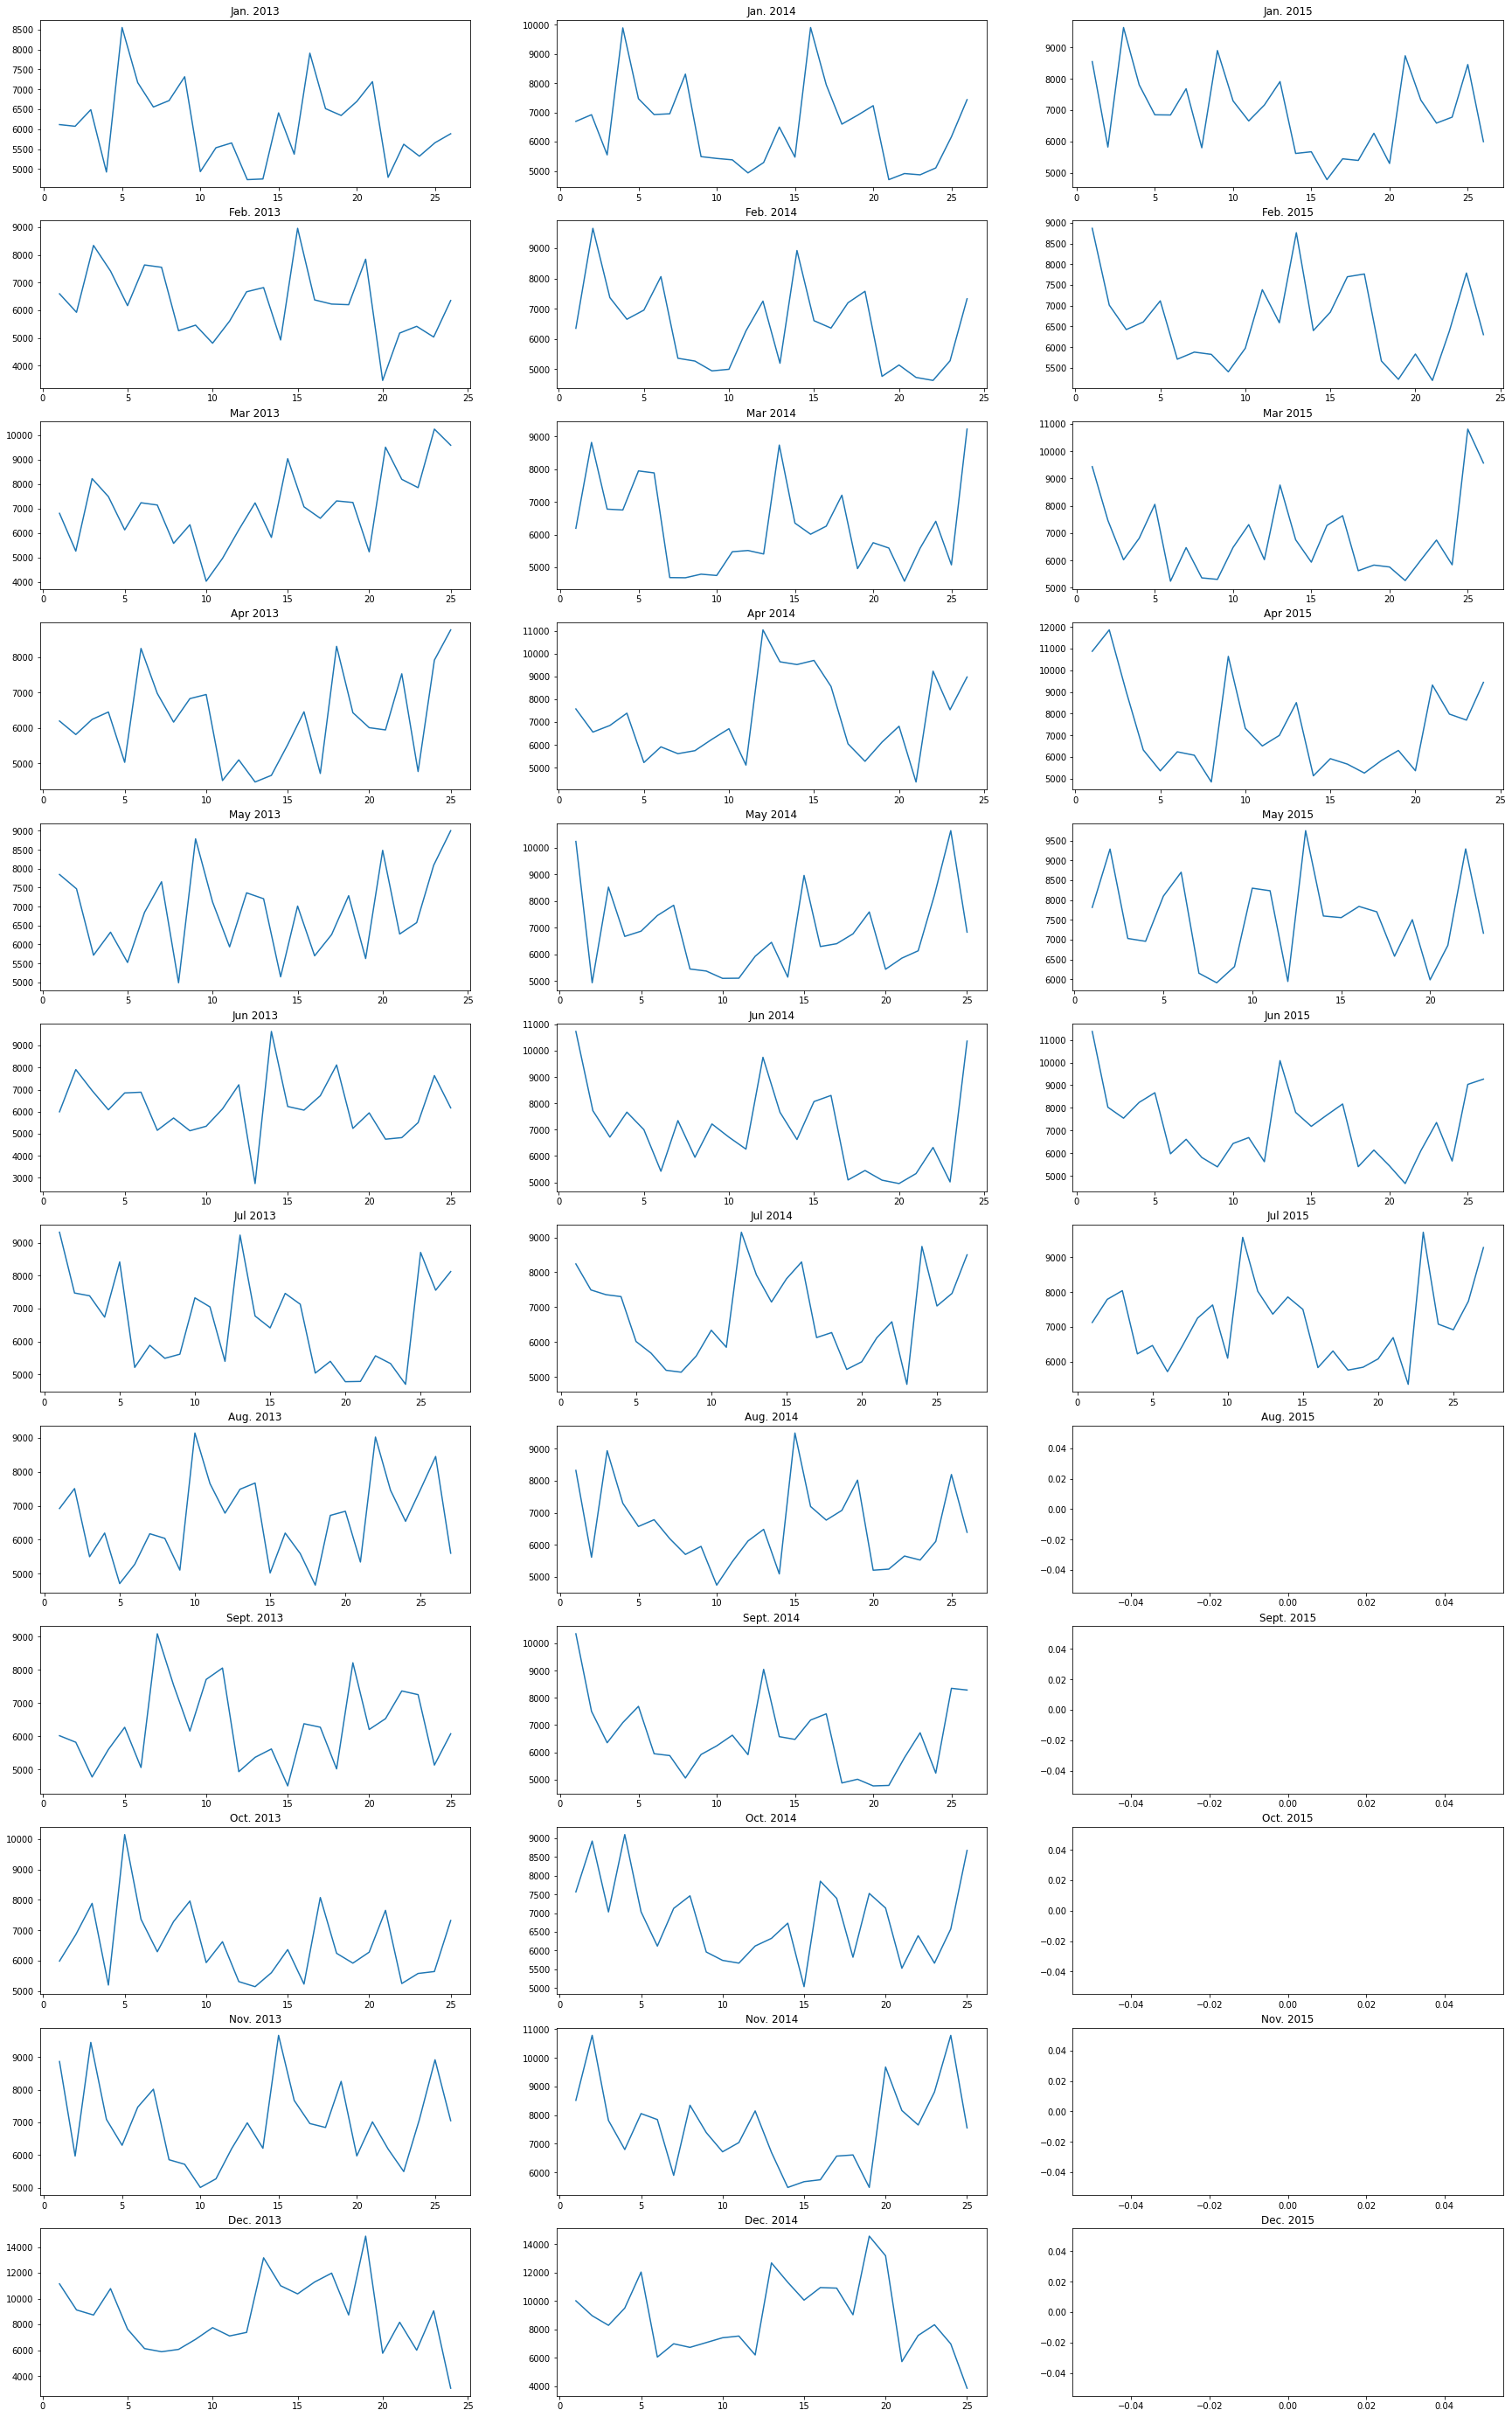

In [47]:
months_name="Jan.,Feb.,Mar,Apr,May,Jun,Jul,Aug.,Sept.,Oct.,Nov.,Dec.".split(',')
years=[2013,2014,2015]
m_idx=0
sales_years=[sales_2013,sales_2014,sales_2015]
rows,cols=12,3

fig,ax=plt.subplots(rows,cols,figsize=(30,50))

for m in range (rows):
    for y in range(cols):
        year_df=sales_years[y]
        ax[m][y].set_title(f"{months_name[m]} {years[y]}")

        month_df=year_df[year_df.Date.dt.month==m+1]
        ax[m][y].plot(range(1,1+len(month_df)),month_df['Sales'])




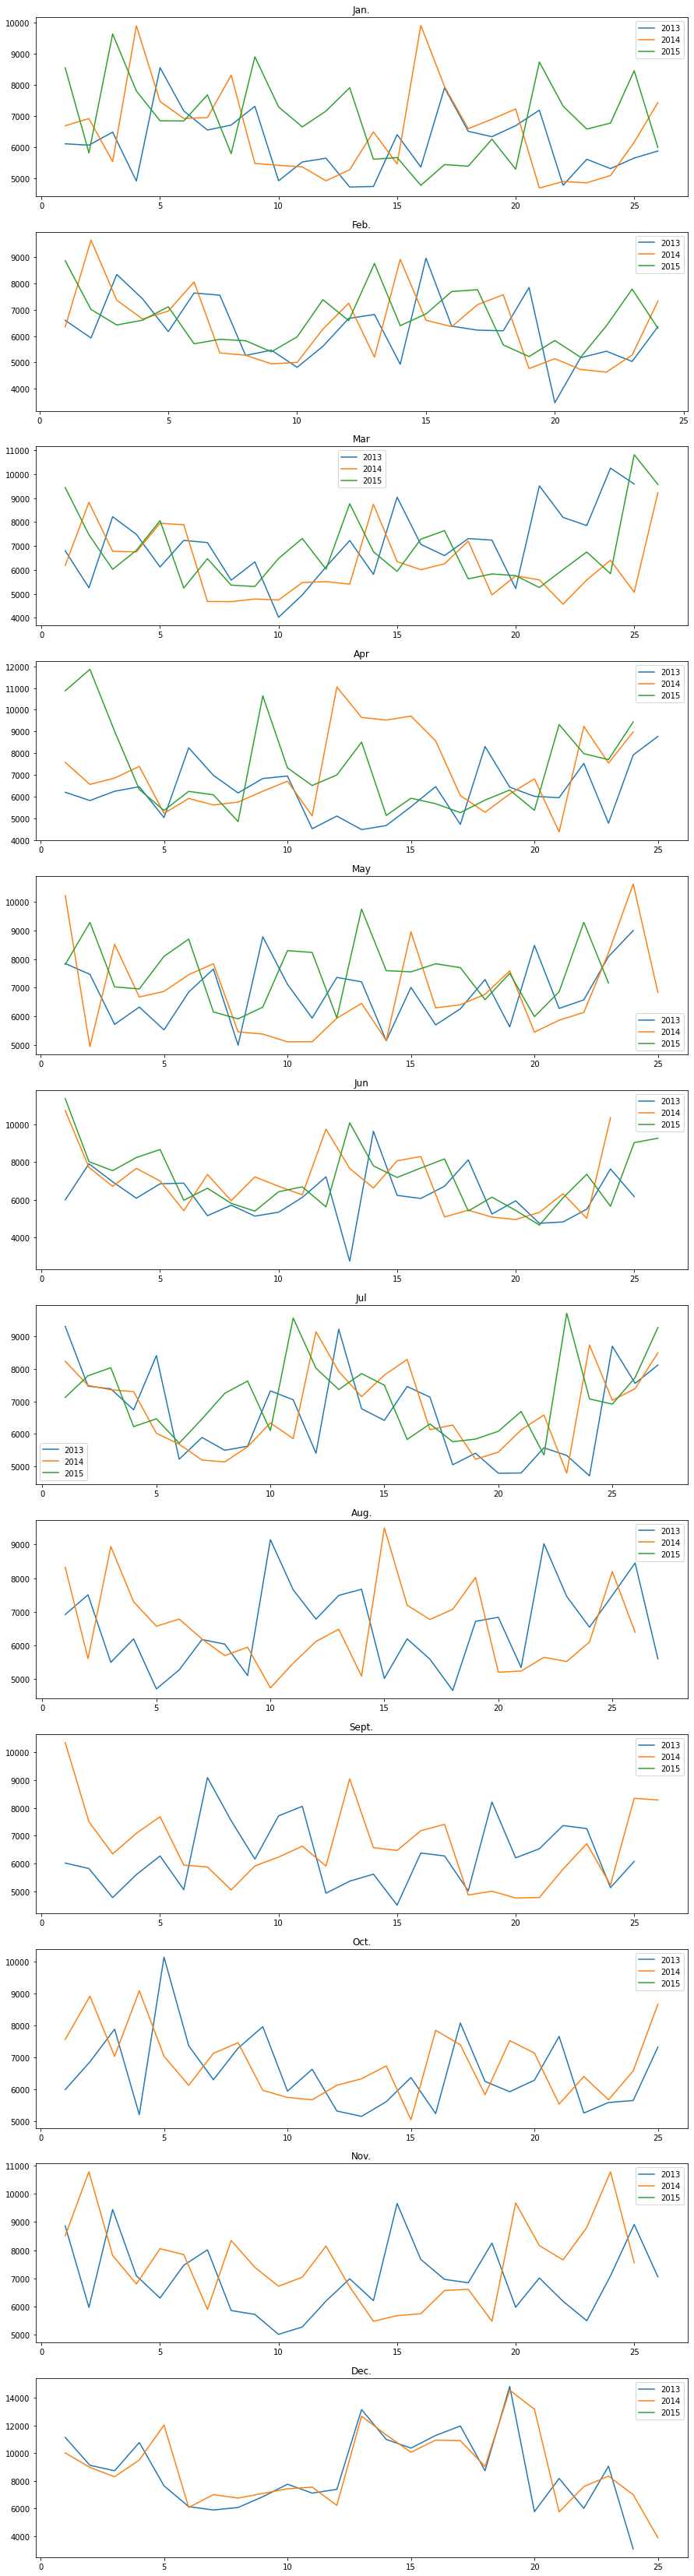

In [48]:
months_name="Jan.,Feb.,Mar,Apr,May,Jun,Jul,Aug.,Sept.,Oct.,Nov.,Dec.".split(',')
years=[2013,2014,2015]
m_idx=0
sales_years=[sales_2013,sales_2014,sales_2015]
rows,cols=12,1

fig,ax=plt.subplots(rows,cols,figsize=(15,60))

for m in range (rows):
    ax[m].set_title(f"{months_name[m]}")
    for y in range(3):
        year_df=sales_years[y]
        month_df=year_df[year_df.Date.dt.month==m+1]
        ax[m].plot(range(1,1+len(month_df)),month_df['Sales'],label=years[y])
        ax[m].legend()

